In [138]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/naomiverkerk/TM10007.git


In [157]:
## Import
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from load_data import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

In [140]:
##Loading Data
data = load_data() 
X = data
X = X.replace(np.inf, np.nan)
Y = data['label']
del X['label']

In [141]:
## Split
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 4, stratify = Y)

print(len(X_train))
print(len(Y_train))

133
133


In [142]:

## Features weghalen met teveel missing values
acceptabele_ratio = 0.5
train_size = len(X_train.index)
removal_rate = round(train_size*acceptabele_ratio)

X_train = X_train.dropna(axis=1, thresh=removal_rate)
common_cols = list(set(X_train.columns).intersection(X_test.columns))
X_test = X_test[common_cols]

In [143]:
## Imputation met median
X_train_missing_median = X_train.fillna(X_train.median())
X_train_missing_median = np.nan_to_num(X_train_missing_median)
X_test_missing_median = X_test.fillna(X_test.median())
X_test_missing_median = np.nan_to_num(X_test_missing_median)

In [144]:
## Scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_train_missing_median)
X_train_scaled = scaler.transform(X_train_missing_median)
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = scaler.transform(X_test_missing_median)
X_test_scaled = np.nan_to_num(X_test_scaled)

In [145]:
## PCA
pca = decomposition.PCA(n_components=0.99, svd_solver= 'full')
pca.fit(X_train_scaled)
X_train_final = pca.transform(X_train_scaled)
X_test_final = pca.transform(X_test_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)


Best classifier: k=19
Best classifier: k=21
Best classifier: k=19
Best classifier: k=25
Best classifier: k=23
The optimal N=21


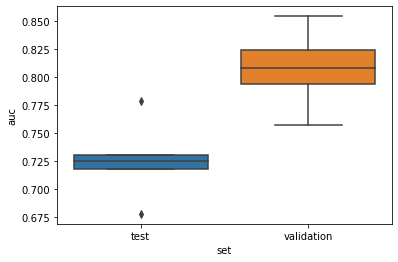

In [254]:
import warnings
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
results = []
best_n_neighbors = []
n_components = []


# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_final, Y_train):
    # Split the data properly
    X_validation = X_train_final[validation_index]
    y_validation = Y_train[validation_index]

    X_test = X_train_final[test_index]
    y_test = Y_train[test_index]

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=5)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")